<a href="https://colab.research.google.com/github/aydawudu/Fraud-Detection-Project/blob/main/ABC_Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ABC Credit Card Fraud Detection

Develop a fraud detection machine learning model that can identify fraudulent credit card transactions in real-time
Analyze historical transaction data from ABC Financial's customers

**Deliverables**:
* Data analysis : EDA
* Model development : Training
* Model assessment : Evaluation


##Loading Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler,\
                         MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics, linear_model, tree, naive_bayes, neighbors,\
                  ensemble, svm, neural_network
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

##EDA

In [5]:
#read in data
data = pd.read_csv('credit_card_transactions', delimiter=',')
data.head()

,customer_id,customer_type,credit_card_type,customer_state,customer_zip,joint_account,has_savings_account,has_checking_account,customer_tenure_months,credit_card_customer_since,transaction_timestamp,transaction_amount,travel_tag,transaction_type,merchant_category,method,last_transaction_date_from_this_merchant,merchant_zip,month_balance,fraud_detected
0,10300,Consumer,Cash Reward,OH,45064.0,N,Y,N,278,2023-10-12,2023-10-13 01:59:00,28.19,N,Purchase,Automotive,Online,2023-10-12 03:32:31,45064,28.19,0
1,10300,Consumer,Cash Reward,OH,45064.0,N,Y,N,278,2023-10-12,2023-10-13 03:47:00,20.33,N,Purchase,Other,Phone,NaN,45064,48.52,0
2,10300,Consumer,Cash Reward,OH,45064.0,N,Y,N,278,2023-10-12,2023-10-13 15:26:00,18.11,N,Purchase,Other,Online,2023-09-29 17:31:48,64762,66.63,0
3,10300,Consumer,Cash Reward,OH,45064.0,N,Y,N,278,2023-10-12,2023-10-15 00:25:00,21.05,N,Purchase,Home & Garden,Mail,2023-10-08 15:19:45,45064,87.68,0
4,10300,Consumer,Cash Reward,OH,45064.0,N,Y,N,278,2023-10-12,2023-10-15 18:09:00,26.57,N,Purchase,Food & Drink,Mail,2023-09-12 00:44:46,43777,114.25,0


In [6]:
#check the data shape
data.shape

(306954, 20)

In [7]:
#Check general info about data
data.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306954 entries, 0 to 306953
Data columns (total 20 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   customer_id                               306954 non-null  int64  
 1   customer_type                             306646 non-null  object 
 2   credit_card_type                          306954 non-null  object 
 3   customer_state                            306954 non-null  object 
 4   customer_zip                              297813 non-null  float64
 5   joint_account                             306954 non-null  object 
 6   has_savings_account                       306954 non-null  object 
 7   has_checking_account                      306954 non-null  object 
 8   customer_tenure_months                    306954 non-null  int64  
 9   credit_card_customer_since                306954 non-null  object 
 10  transaction_timestam

In [8]:
#Summary stats for numerical data
data.describe().applymap(lambda x: round(x, 0))

<ipython-input-8-7a67e96ce803>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data.describe().applymap(lambda x: round(x, 0))


,customer_id,customer_zip,customer_tenure_months,transaction_amount,merchant_zip,month_balance,fraud_detected
count,306954.0,297813.0,306954.0,306919.0,306954.0,306954.0,306954.0
mean,56463.0,37370.0,179.0,61.0,39053.0,2272.0,0.0
std,26425.0,32897.0,97.0,140.0,30277.0,3386.0,0.0
min,10300.0,1028.0,0.0,-8949.0,1001.0,-3172.0,0.0
25%,33667.0,10591.0,95.0,22.0,12946.0,560.0,0.0
50%,57510.0,21133.0,181.0,31.0,32439.0,1347.0,0.0
75%,80588.0,62951.0,264.0,65.0,62274.0,2758.0,0.0
max,100640.0,96002.0,347.0,30381.0,99901.0,68489.0,1.0


In [9]:
#summary stats for categorical data
data.describe(include='object')

,customer_type,credit_card_type,customer_state,joint_account,has_savings_account,has_checking_account,credit_card_customer_since,transaction_timestamp,travel_tag,transaction_type,merchant_category,method,last_transaction_date_from_this_merchant
count,306646,306954,306954,306954,306954,306954,306954,306954,303816,306593,303956,306954,245433
unique,5,3,11,2,2,2,551,227842,2,6,10,3,240841
top,Consumer,Cash Unlimited,CA,N,Y,Y,2013-11-01,2023-07-18 17:04:00,N,Purchase,Food & Drink,Mail,2023-02-21 23:58:22
freq,228312,154694,54778,231069,215677,186732,3365,7,273568,268605,30528,102572,3


In [10]:
#Checking for Missing Values by calculating the percentage per column
(data.isnull().sum()/len(data)*100).sort_values(ascending = False).head(50).round(2)

,0
last_transaction_date_from_this_merchant,20.04
customer_zip,2.98
travel_tag,1.02
merchant_category,0.98
transaction_type,0.12
customer_type,0.10
transaction_amount,0.01
customer_id,0.00
month_balance,0.00
merchant_zip,0.00


####Visualize Missing Values

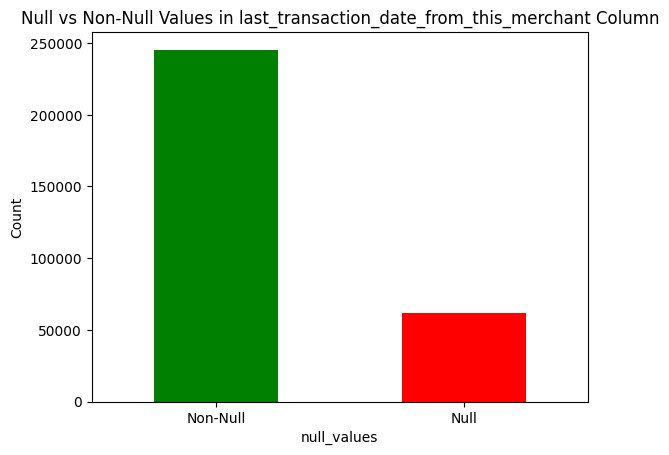

In [11]:
# Assuming df is your dataframe and 'last_transaction_date_from_this_merchant' is the column of interest
data['null_values'] = data['last_transaction_date_from_this_merchant'].isnull()

# Plotting the count of null and non-null values
data['null_values'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Null vs Non-Null Values in last_transaction_date_from_this_merchant Column')
plt.xticks(ticks=[0, 1], labels=['Non-Null', 'Null'], rotation=0)
plt.ylabel('Count')
plt.show()

In [18]:
#check target variable percentage
data['fraud_detected'].value_counts()

,count
fraud_detected,
0,303805
1,3149


In [14]:
#calculate percentage
(data['fraud_detected'].value_counts()/len(data)*100).round(2)

,count
fraud_detected,
0,98.97
1,1.03


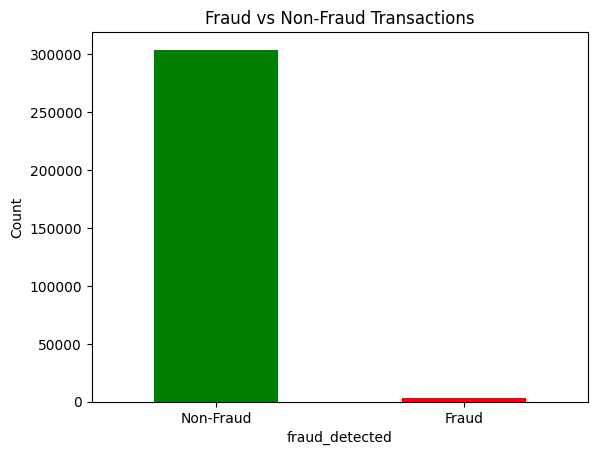

In [12]:
#plot target variable
data['fraud_detected'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Fraud vs Non-Fraud Transactions')
plt.xticks(ticks=[0, 1], labels=['Non-Fraud', 'Fraud'], rotation=0)
plt.ylabel('Count')
plt.show()

In [ ]:
# Create a new column to indicate whether the date is null
data['null_values'] = data['last_transaction_date_from_this_merchant'].isnull()

# Group by the target column and the null status to calculate the fraud rate
fraud_rate_by_null = data.groupby(['null_values', 'fraud_detected']).size().unstack().fillna(0)

# Calculate the fraud rate
fraud_rate_by_null['fraud_rate'] = fraud_rate_by_null[1] / (fraud_rate_by_null[0] + fraud_rate_by_null[1])
fraud_rate_by_null

fraud_detected,0,1,fraud_rate
null_values,,,
False,242907,2526,0.010292
True,60898,623,0.010127


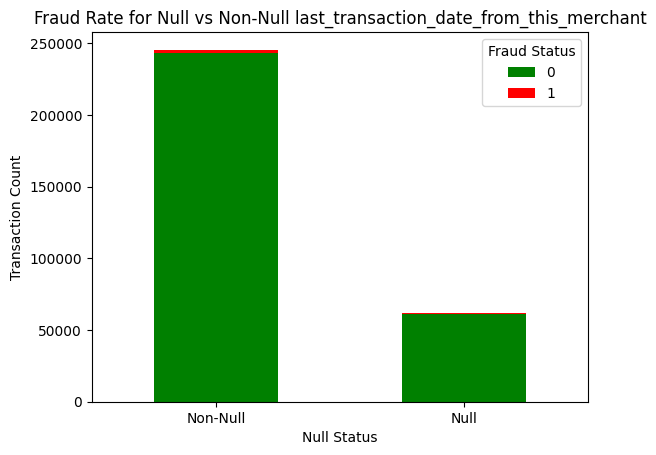

In [ ]:
# Create a new column to indicate whether the date is null
data['null_values'] = data['last_transaction_date_from_this_merchant'].isnull()

# Group by the target column and the null status to calculate the fraud rate
fraud_rate_by_null = data.groupby(['null_values', 'fraud_detected']).size().unstack().fillna(0)

# Plotting the bar chart
fraud_rate_by_null.plot(kind='bar', stacked=True, color=['green', 'red'])
plt.title('Fraud Rate for Null vs Non-Null last_transaction_date_from_this_merchant')
plt.xlabel('Null Status')
plt.ylabel('Transaction Count')
plt.xticks(ticks=[0, 1], labels=['Non-Null', 'Null'], rotation=0)
plt.legend(title='Fraud Status')
plt.show()

#### Numerical Columns Distribution

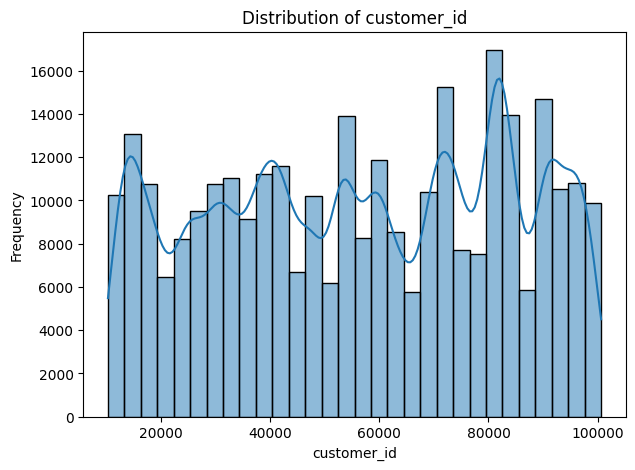

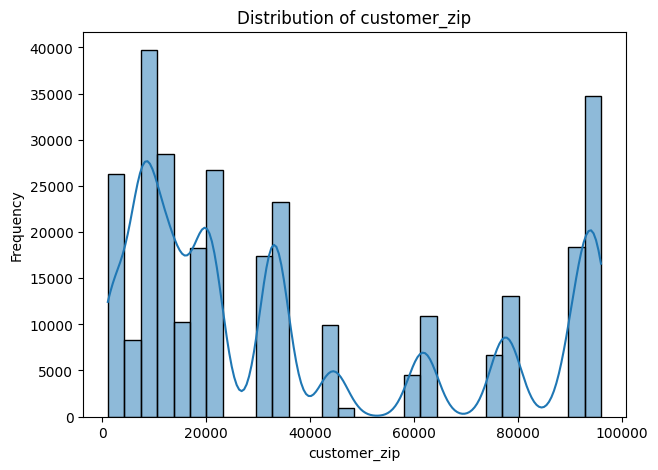

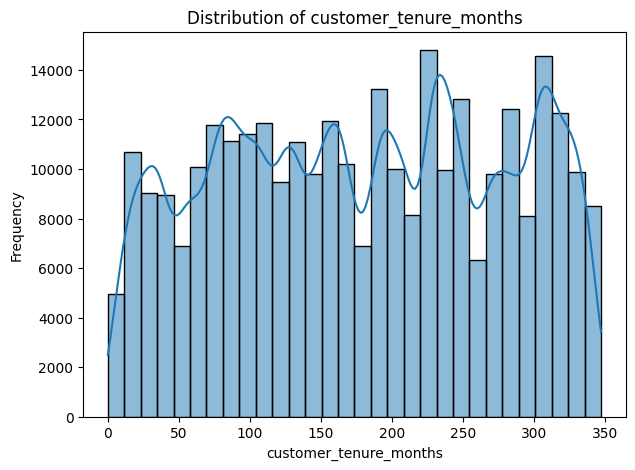

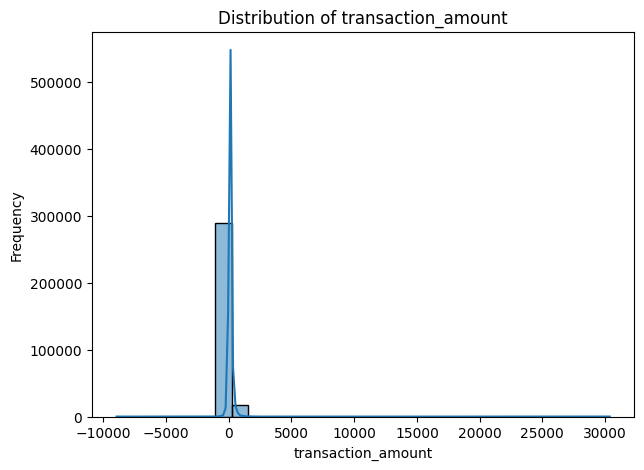

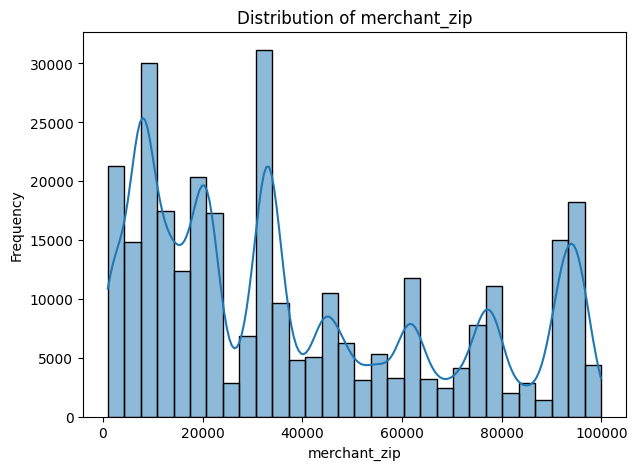

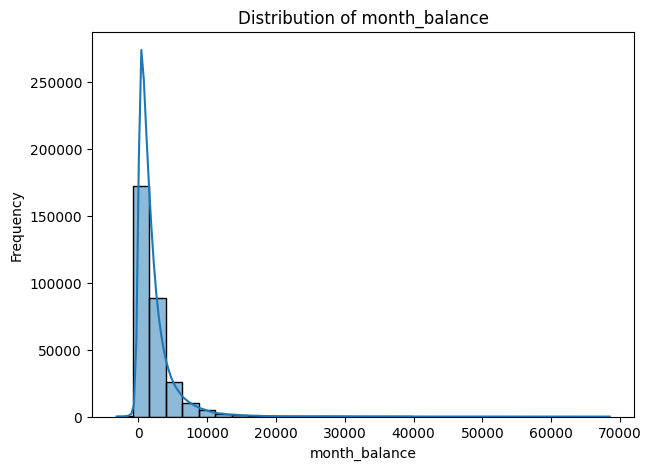

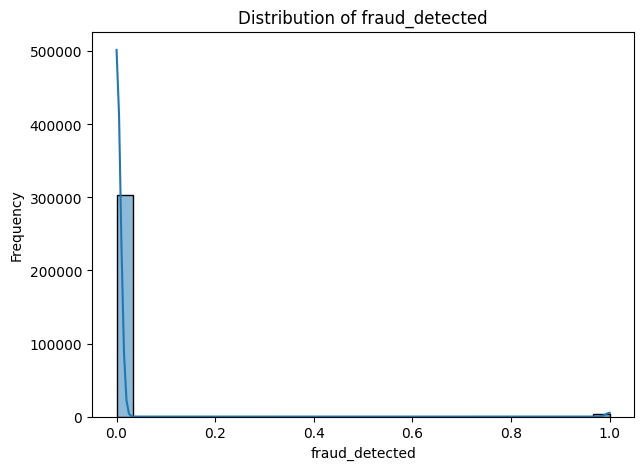

In [ ]:
#visualize numerical columns
numerical_columns = data.select_dtypes(include=[np.number]).columns
for col in numerical_columns:
    plt.figure(figsize=(7, 5))
    sns.histplot(data[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

#### Categorical Columns Count

In [ ]:
 # preprocess datetime columns
data['credit_card_customer_since'] = pd.to_datetime(data['credit_card_customer_since'])
data['transaction_timestamp'] = pd.to_datetime(data['transaction_timestamp'])
data['last_transaction_date_from_this_merchant'] = pd.to_datetime(data['last_transaction_date_from_this_merchant'])

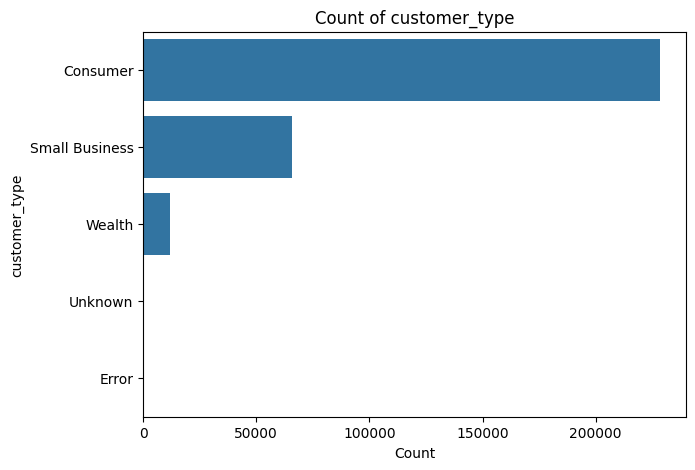

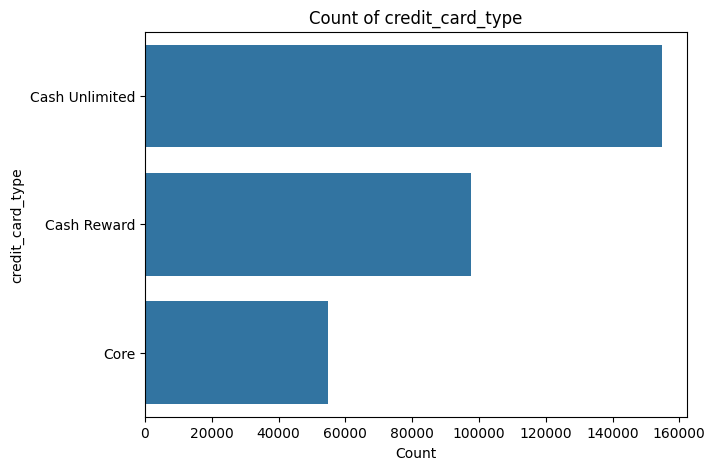

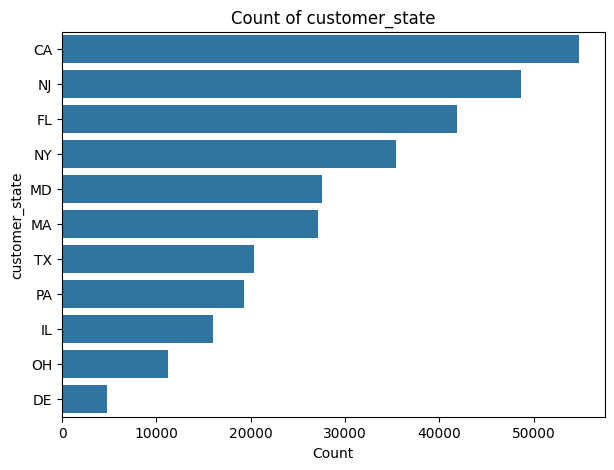

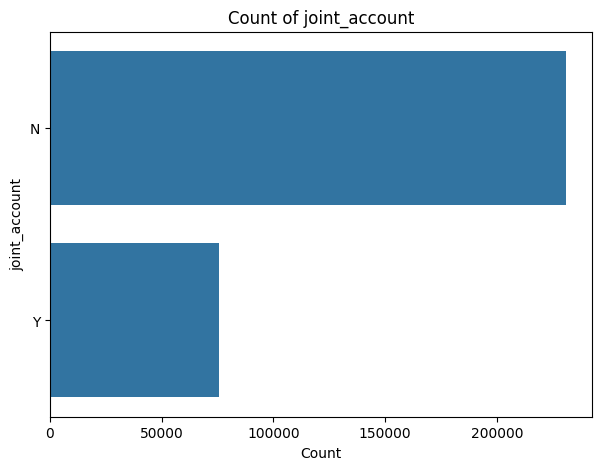

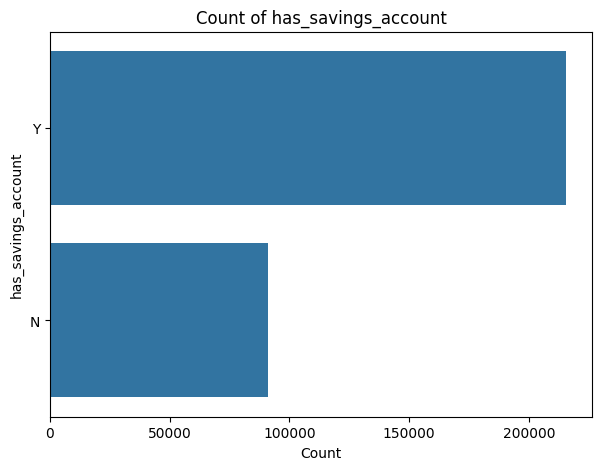

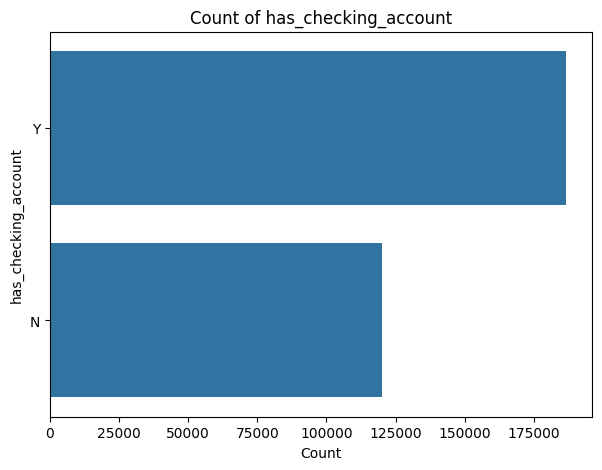

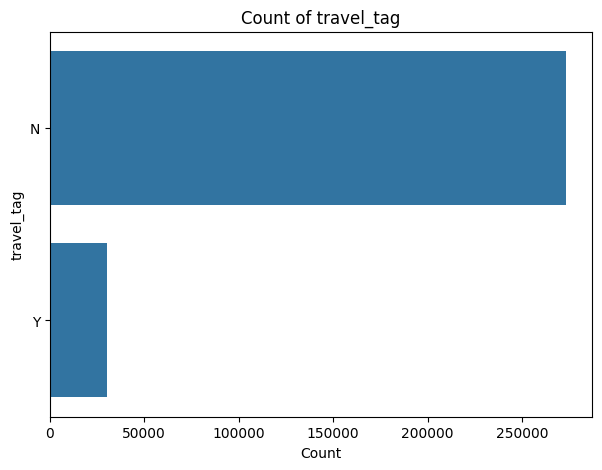

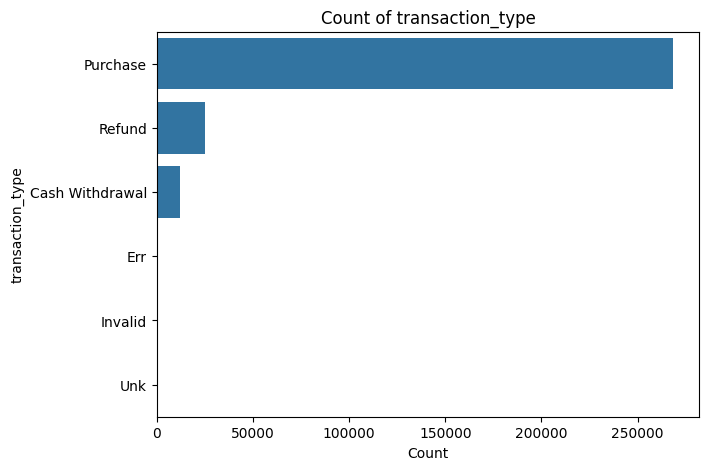

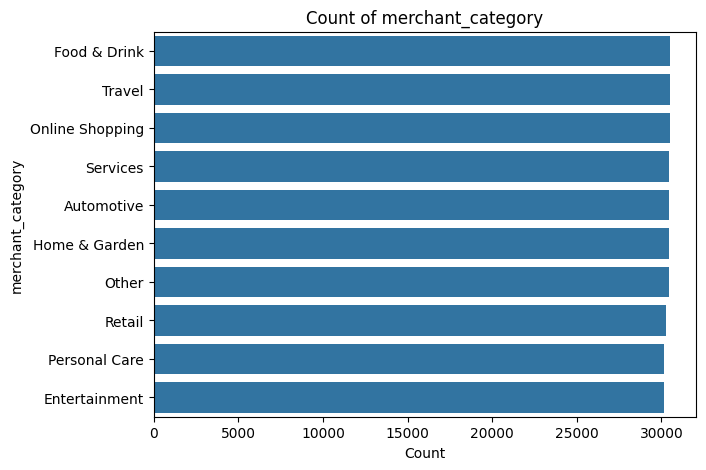

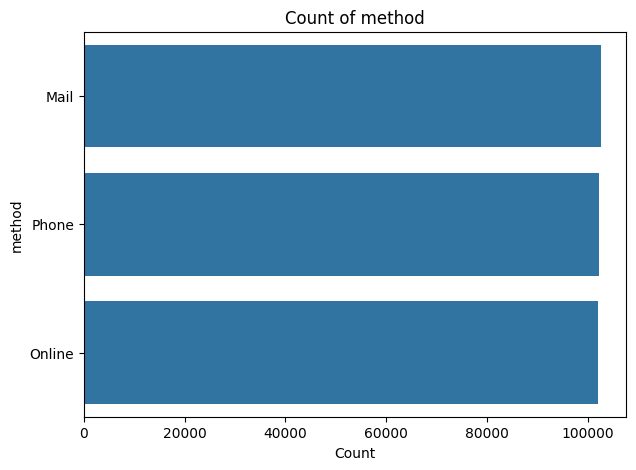

In [ ]:
#visualize categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    plt.figure(figsize=(7,5))
    sns.countplot(y=col, data=data, order=data[col].value_counts().index)
    plt.title(f'Count of {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


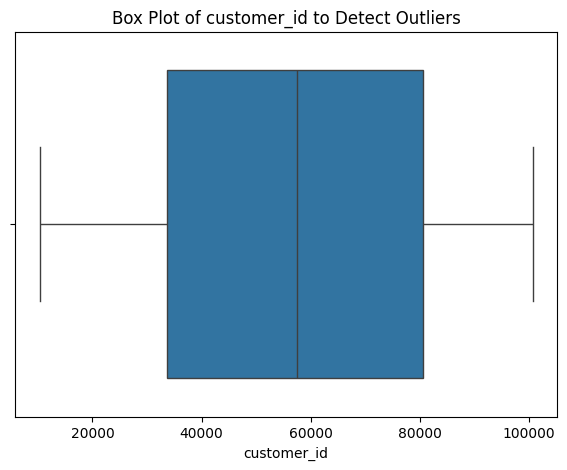

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


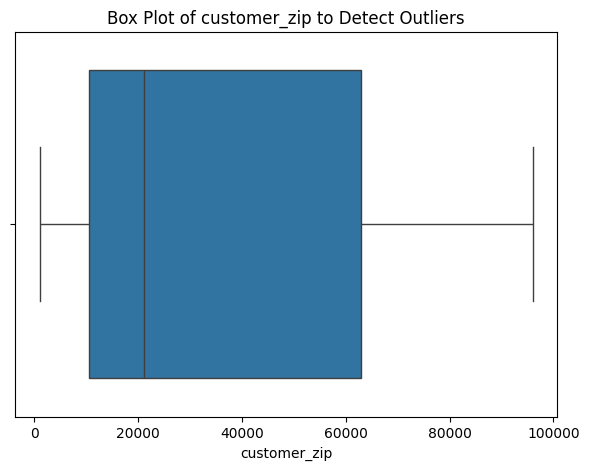

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


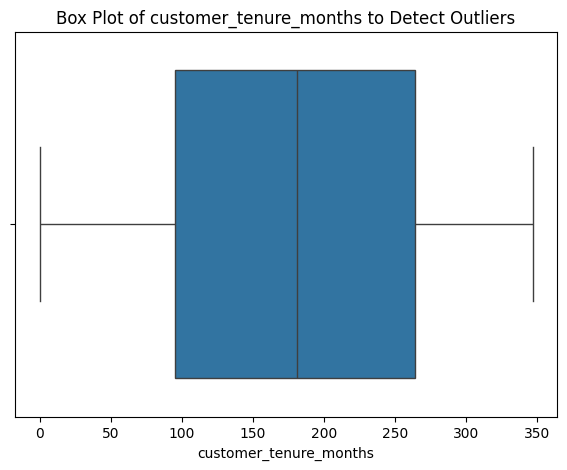

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


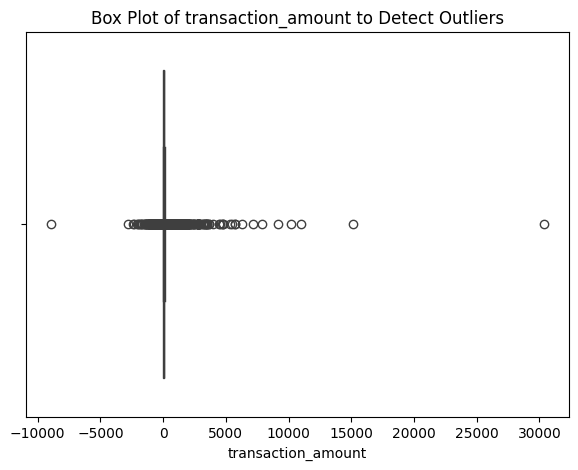

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


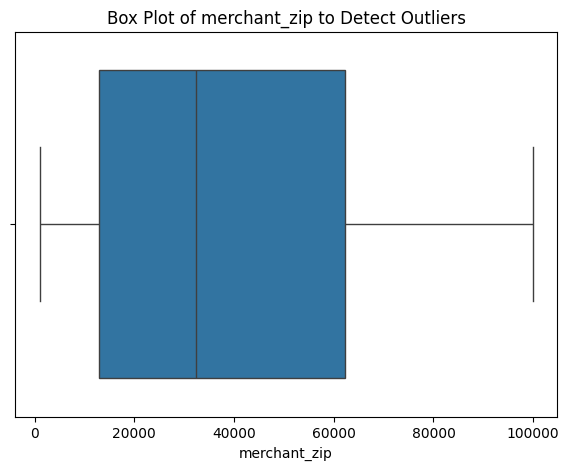

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


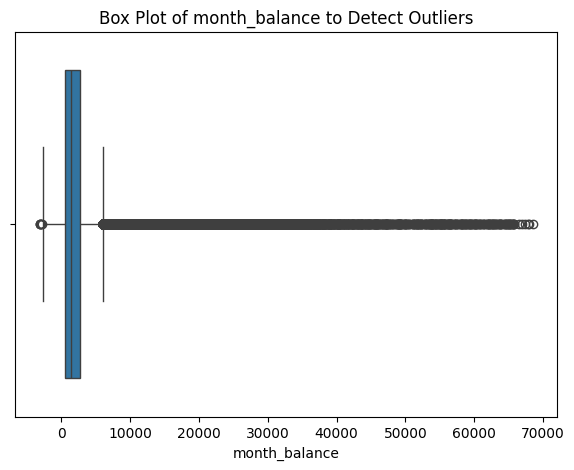

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


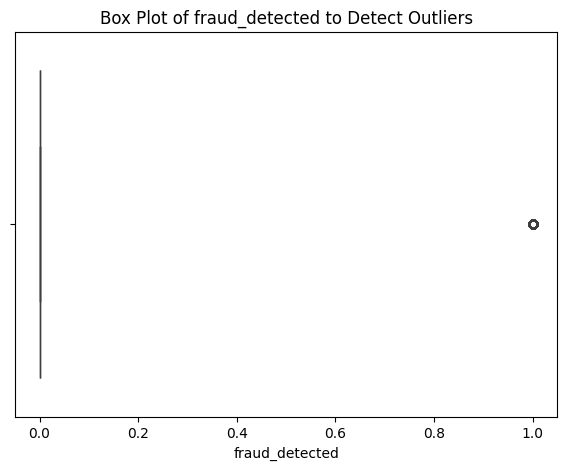

In [ ]:
#check of outliers using box plots
for col in numerical_columns:
    plt.figure(figsize=(7, 5))
    sns.boxplot(x=data[col])
    plt.title(f'Box Plot of {col} to Detect Outliers')
    plt.xlabel(col)
    plt.show()

## Data Preprocessing

In [ ]:
# copy data
df=data.copy()

In [ ]:
df.head()

,customer_id,customer_type,credit_card_type,customer_state,customer_zip,joint_account,has_savings_account,has_checking_account,customer_tenure_months,credit_card_customer_since,...,transaction_amount,travel_tag,transaction_type,merchant_category,method,last_transaction_date_from_this_merchant,merchant_zip,month_balance,fraud_detected,null_values
0,10300,Consumer,Cash Reward,OH,45064.0,N,Y,N,278,2023-10-12,...,28.19,N,Purchase,Automotive,Online,2023-10-12 03:32:31,45064,28.19,0,False
1,10300,Consumer,Cash Reward,OH,45064.0,N,Y,N,278,2023-10-12,...,20.33,N,Purchase,Other,Phone,NaT,45064,48.52,0,True
2,10300,Consumer,Cash Reward,OH,45064.0,N,Y,N,278,2023-10-12,...,18.11,N,Purchase,Other,Online,2023-09-29 17:31:48,64762,66.63,0,False
3,10300,Consumer,Cash Reward,OH,45064.0,N,Y,N,278,2023-10-12,...,21.05,N,Purchase,Home & Garden,Mail,2023-10-08 15:19:45,45064,87.68,0,False
4,10300,Consumer,Cash Reward,OH,45064.0,N,Y,N,278,2023-10-12,...,26.57,N,Purchase,Food & Drink,Mail,2023-09-12 00:44:46,43777,114.25,0,False


#### Fill missing values in columns

In [ ]:
# Fill missing values in datetime columns with the mode
date_columns = df.select_dtypes(include=['datetime']).columns

for col in date_columns:
    if df[col].isnull().sum() > 0:
        mode_value = df[col].mode()
        if not mode_value.empty:
            # Fill missing values with mode and assign back to the DataFrame
            df[col] = df[col].fillna(mode_value[0])
            print(f"Filled missing values in '{col}' with mode: {mode_value[0]}")
        else:
            print(f"No mode found for '{col}', missing values remain.")

Filled missing values in 'last_transaction_date_from_this_merchant' with mode: 2022-12-20 11:46:46


In [ ]:
# Fill missing values in numerical columns with the mean
num_columns = df.select_dtypes(include=['float64', 'int64']).columns

for col in num_columns:
    if df[col].isnull().sum() > 0:
        # Fill missing values with mean and assign back to the DataFrame
        df[col] = df[col].fillna(df[col].mean())
        print(f"Filled missing values in '{col}' with mean: {df[col].mean()}")

Filled missing values in 'customer_zip' with mean: 37370.4863219537
Filled missing values in 'transaction_amount' with mean: 61.151759433518066


In [ ]:
# Fill missing values in categorical columns with the mode
cat_columns = df.select_dtypes(include=['object']).columns

for col in cat_columns:
    if df[col].isnull().sum() > 0:
        mode_value = df[col].mode()

        if not mode_value.empty:
            # Fill missing values with mode and assign back to the DataFrame
            df[col] = df[col].fillna(mode_value[0])
            print(f"Filled missing values in '{col}' with mode: {mode_value[0]}")
        else:
            print(f"No mode found for '{col}', missing values remain.")

Filled missing values in 'customer_type' with mode: Consumer
Filled missing values in 'travel_tag' with mode: N
Filled missing values in 'transaction_type' with mode: Purchase
Filled missing values in 'merchant_category' with mode: Food & Drink


In [ ]:
#derive day of week, month of year and year
df['credit_card_customer_since_day'] = df['credit_card_customer_since'].dt.day
df['credit_card_customer_since_month'] = df['credit_card_customer_since'].dt.month
df['credit_card_customer_since_year'] = df['credit_card_customer_since'].dt.year

df['transaction_date_day'] = df['transaction_timestamp'].dt.day
df['transaction_date_month'] = df['transaction_timestamp'].dt.month
df['transaction_date_year'] = df['transaction_timestamp'].dt.year

df['last_transaction_date_from_this_merchant_day'] = df['last_transaction_date_from_this_merchant'].dt.day
df['last_transaction_date_from_this_merchant_month'] = df['last_transaction_date_from_this_merchant'].dt.month
df['last_transaction_date_from_this_merchant_year'] = df['last_transaction_date_from_this_merchant'].dt.year

#drop full datetime stamp columns
df.drop(['credit_card_customer_since', 'transaction_timestamp', 'last_transaction_date_from_this_merchant'], axis=1, inplace=True)

#### Encode the categorical colums

In [ ]:
#get categorical columns
cat_columns=df.select_dtypes(include=['object']).columns
print(f"Categorical columns: {cat_columns}")

Categorical columns: Index(['customer_type', 'credit_card_type', 'customer_state', 'joint_account',
       'has_savings_account', 'has_checking_account', 'travel_tag',
       'transaction_type', 'merchant_category', 'method'],
      dtype='object')


In [ ]:
#initialize OneHotEncoder
encoder= OneHotEncoder(sparse_output=False, handle_unknown='ignore')
#fit and transform data
encoded_data=encoder.fit_transform(df[cat_columns])

#create dataframe with encoded data
encoded_df=pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(cat_columns))

#drop original categorical columns
df.drop(cat_columns, axis=1, inplace=True)

#concatenate original dataframe with encoded dataframe
df_cleaned=pd.concat([df, encoded_df], axis=1)

#### Dataset Target Imbalance

In [ ]:
#check target variable
df_cleaned['fraud_detected'].value_counts()

,count
fraud_detected,
0,303805
1,3149


In [ ]:
# #Apply oversampling
X = df_cleaned.drop('fraud_detected', axis=1)
y = df_cleaned['fraud_detected']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

#### Split data for training

In [ ]:
# Split cleaned data into test and train sets
rand=42
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=rand)

## Model Training

In [ ]:
class_models = {
        #Generalized Linear Models (GLMs)
        'logistic':{'model': linear_model.LogisticRegression()},
        #Tree
        'decision_tree':{'model': tree.DecisionTreeClassifier(max_depth=7, random_state=rand)},
        #Naive Bayes
        'naive_bayes':{'model': naive_bayes.GaussianNB()},
        #Ensemble Method: Gradient Boosting
        'gradient_boosting':{'model':ensemble.GradientBoostingClassifier(n_estimators=210)},
        #Ensemble Method: Random Forest
        'random_forest':{'model':ensemble.RandomForestClassifier(max_depth=11,\
                                                            class_weight='balanced', random_state=rand)},
        #Ensemble Method: XGBoost
        'xgboost':{'model':XGBClassifier(n_estimators=210, random_state=rand)},

        #ArtificiaL Neural Networks
        'mlp':{'model':make_pipeline(StandardScaler(),\
                                     neural_network.MLPClassifier(hidden_layer_sizes=(7,), max_iter=500,\
                                                   early_stopping=True, random_state=rand))}
    }

In [ ]:
%%time
for model_name in class_models.keys():
    print(model_name)
    fitted_model = class_models[model_name]['model'].fit(X_train, y_train)
    y_train_pred = fitted_model.predict(X_train)
    y_test_prob = fitted_model.predict_proba(X_test)[:,1]
    y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
    class_models[model_name]['fitted'] = fitted_model
    class_models[model_name]['probs'] = y_test_prob
    class_models[model_name]['preds'] = y_test_pred
    class_models[model_name]['Accuracy_train'] = metrics.accuracy_score(y_train, y_train_pred)
    class_models[model_name]['Accuracy_test'] = metrics.accuracy_score(y_test, y_test_pred)
    class_models[model_name]['Recall_train'] = metrics.recall_score(y_train, y_train_pred)
    class_models[model_name]['Recall_test'] = metrics.recall_score(y_test, y_test_pred)
    class_models[model_name]['Precision_train'] = metrics.precision_score(y_train, y_train_pred)
    class_models[model_name]['Precision_test'] = metrics.precision_score(y_test, y_test_pred)
    class_models[model_name]['F1_test'] = metrics.f1_score(y_test, y_test_pred)

logistic


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


decision_tree
naive_bayes
gradient_boosting
random_forest
xgboost
mlp
CPU times: user 16min 40s, sys: 16.1 s, total: 16min 56s
Wall time: 16min 12s


## Model Evaluation on Train and Test Data

In [ ]:
class_metrics = pd.DataFrame.from_dict(class_models, 'index')[['Accuracy_train', 'Accuracy_test',\
                                                               'Recall_train', 'Recall_test',\
                                                               'Precision_train', 'Precision_test',\
                                                               'F1_test']]
class_metrics.sort_values(by='F1_test', ascending=False).style.\
    format(dict(zip(class_metrics.columns, ['{:.3f}']*7))).\
    background_gradient(cmap='plasma', low=1, high=0.1, subset=['Accuracy_train', 'Accuracy_test']).\
    background_gradient(cmap='viridis', low=1, high=0.1, subset=['Recall_train', 'Recall_test',\
                                                                 'Precision_train', 'Precision_test',\
                                                                  'F1_test' ])

,Accuracy_train,Accuracy_test,Recall_train,Recall_test,Precision_train,Precision_test,F1_test
xgboost,0.994,0.993,0.988,0.986,1.000,1.000,0.993
gradient_boosting,0.985,0.986,0.970,0.972,1.000,1.000,0.986
random_forest,0.970,0.971,0.942,0.943,0.999,0.999,0.970
decision_tree,0.931,0.931,0.864,0.864,0.997,0.997,0.926
mlp,0.892,0.894,0.810,0.813,0.970,0.970,0.885
naive_bayes,0.607,0.608,0.933,0.932,0.564,0.566,0.704
logistic,0.543,0.542,0.667,0.666,0.535,0.535,0.593


In [ ]:
## Model Saving

import pickle


# Step 1: Select a model (e.g., 'logistic')
selected_model = class_models['xgboost']['model']

# Step 2: Train the model
selected_model.fit(X_train, y_train)

# Step 3: Save the trained model using pickle
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(selected_model, file)

### Additional Insight

<Figure size 1000x600 with 0 Axes>

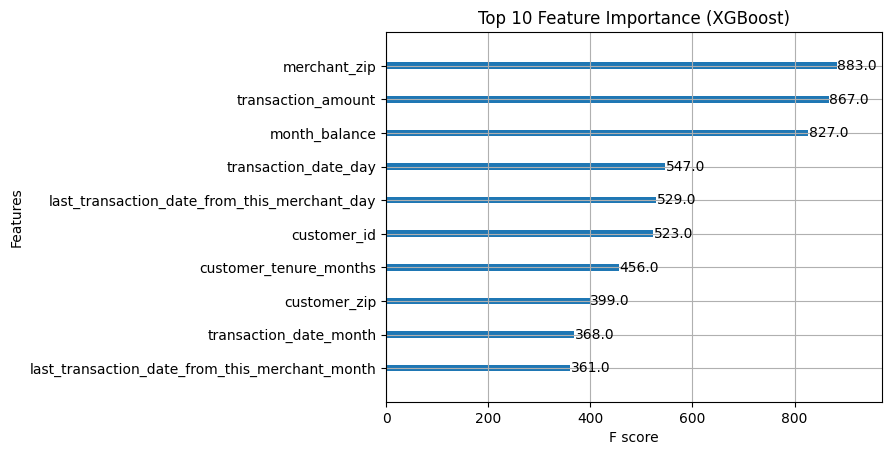

In [ ]:
## Feature Importance
# Step 2: Get feature importance scores

from xgboost import plot_importance
xgb_model = class_models['xgboost']['model']

feature_importance = xgb_model.feature_importances_

# If you have feature names, it is useful to associate them with their importance
# Assuming your features are in a DataFrame or have names
if isinstance(X_train, pd.DataFrame):
    feature_names = X_train.columns
else:
    feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]

# Create a DataFrame for easier viewing
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Step 3 (Optional): Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, importance_type='weight', max_num_features=10)
plt.title('Top 10 Feature Importance (XGBoost)')
plt.show()

# Display the feature importance DataFrame
print(importance_df)